  # Activity 6 Local information storage

In this activity we will examine Active Information Storage (AIS) in Elementary Cellular Automata rule 54.  
CAs are wonderful canonical systems to use to explore dynamics of self-organisation in complex systems, in particular regarding emergent structures such as blinkers, gliders and collisions.    
If you have not played around with CAs before, you can explore dynamics of ECAs using NetLogo via Sample models | Computer Science | Cellular Automata | CA 1D Elementary in the Models Library (or access via NetLogo web (Links to an external site.) if you don't have an installation): try rules 2, 8, 18, 30, 54, 90, 110, 146, and 254 to see a variety of dynamics.   


In this example we will compute the appropriate embedding length manually,    
and then go on to examine local AIS values and how they relate to emergent structure.

In [8]:
#---------------------------------------------------
# START JVM
#-----------------------------------------------------

from jpype import startJVM, getDefaultJVMPath, JArray, JInt, JPackage, shutdownJVM, isJVMStarted
import numpy as np
import sys
# Our python data file readers are a bit of a hack, python users will do better on this:
sys.path.append("/home/jovyan/notebooks/jidt/demos/python")
import readIntsFile

# Add JIDT jar library to the path
jarLocation = "/home/jovyan/notebooks/jidt/infodynamics.jar"
# Start the JVM (add the "-Xmx" option with say 1024M if you get crashes due to not enough memory space)
if (not isJVMStarted()):
    startJVM(getDefaultJVMPath(), "-ea", "-Djava.class.path=" + jarLocation)

javaIntList = lambda l : JArray(JInt, 1)(l)

In [9]:
# LOAD DATA FILE
#-------------------

import pandas as pd
#from pathlib import Path

filename = './data/ca54.txt'
data = pd.read_csv(filename, delim_whitespace=True, comment='%', header=None, index_col=None)
source = data.to_numpy()
source.shape

(600, 10000)

## 4. 
Examine how the code is computing the AIS for each cell. In Matlab change the directory now to demos/AutoAnalyser   
or wherever you have moved the generated code file, and run GeneratedCalculator.   
Notice the calculation for each cell printed in your console window, and notice the variance in these.   
We would get a much more accurate result if we could make an AIS estimation by pooling all of the samples for the different cells together.     
Reflect on why pooling the samples for technically different time-series processes is valid here, and think of a data set where it would not be a valid approach.


we can pool them because we see those time series they could be different realizations of the same process

In [10]:
history_k=1

# 1. Construct the calculator:
calcClass = JPackage("infodynamics.measures.discrete").ActiveInformationCalculatorDiscrete
calc = calcClass(2, history_k)
# 2. No other properties to set for discrete calculators.

#for i in range(source.shape[1]):
for i in range(10):
    
    # 3. Initialise the calculator for (re-)use:
    calc.initialise()
    # 4. Supply the sample data:
    calc.addObservations(javaIntList(source[:,i].tolist()))
    # 5. Compute the estimate:
    result = calc.computeAverageLocalOfObservations()
    print(f'Result obtained from {calc.getNumObservations()} samples')
    # 6. Compute the (statistical significance via) null distribution empirically (e.g. with 100 permutations):
    measDist = calc.computeSignificance(100)

    if (i % 1) == 0:
        print("AIS_Discrete(col_0) = %.4f bits (null: %.4f +/- %.4f std dev.; p(surrogate > measured)=%.5f from %d surrogates)" %
        (result, measDist.getMeanOfDistribution(), measDist.getStdOfDistribution(), measDist.pValue, 100))

    bias = measDist.getMeanOfDistribution()

    result_p = float(result)
    bias_p = float(bias)



Result obtained from 599 samples
AIS_Discrete(col_0) = 0.2198 bits (null: 0.0014 +/- 0.0017 std dev.; p(surrogate > measured)=0.00000 from 100 surrogates)
Result obtained from 599 samples
AIS_Discrete(col_0) = 0.1186 bits (null: 0.0012 +/- 0.0017 std dev.; p(surrogate > measured)=0.00000 from 100 surrogates)
Result obtained from 599 samples
AIS_Discrete(col_0) = 0.2140 bits (null: 0.0013 +/- 0.0015 std dev.; p(surrogate > measured)=0.00000 from 100 surrogates)
Result obtained from 599 samples
AIS_Discrete(col_0) = 0.1109 bits (null: 0.0012 +/- 0.0016 std dev.; p(surrogate > measured)=0.00000 from 100 surrogates)
Result obtained from 599 samples
AIS_Discrete(col_0) = 0.2198 bits (null: 0.0014 +/- 0.0018 std dev.; p(surrogate > measured)=0.00000 from 100 surrogates)
Result obtained from 599 samples
AIS_Discrete(col_0) = 0.1167 bits (null: 0.0017 +/- 0.0020 std dev.; p(surrogate > measured)=0.00000 from 100 surrogates)
Result obtained from 599 samples
AIS_Discrete(col_0) = 0.2198 bits (nu

# Pooling cells together

In [11]:
history_k=1

def pooledAIS(source, history_k):
    # 1. Construct the calculator:
    calcClass = JPackage("infodynamics.measures.discrete").ActiveInformationCalculatorDiscrete
    calc = calcClass(2, history_k)
    # 2. No other properties to set for discrete calculators.

        
    # 3. Initialise the calculator for (re-)use:
    calc.initialise()

    for i in range(source.shape[1]):
        # 4. Supply the sample data:
        calc.addObservations(javaIntList(source[:,i].tolist()))
        # 5. Compute the estimate:
    result = calc.computeAverageLocalOfObservations()
    print(f'Result obtained from {calc.getNumObservations()} samples : AIS_Discrete = {result} bits ')
    # 6. Compute the (statistical significance via) analytically
    measDist = calc.computeSignificance()

    if (i % 1) == 0:
        print("AIS_Discrete = %.4f bits (null: %.4f +/- %.4f std dev.; p(surrogate > measured)=%.5f )" %
        (result, measDist.getMeanOfDistribution(), measDist.getStdOfDistribution(), measDist.pValue))

    bias = measDist.getMeanOfDistribution()

    result_p = float(result)
    bias_p = float(bias)
    print(result_p, bias_p)
    return result_p, result_p - bias_p, bias_p

In [12]:
ks=range(1,20)
results=[]
results_corrected=[]
biases=[]
for k in range(1,20):
    result, result_corrected, bias = pooledAIS(source, k)
    results.append(result)
    results_corrected.append(result_corrected)
    biases.append(bias)

Result obtained from 5990000 samples : AIS_Discrete = 0.14262157269805384 bits 
AIS_Discrete = 0.1426 bits (null: 0.0000 +/- 0.0000 std dev.; p(surrogate > measured)=0.00000 )
0.14262157269805384 8.347245409015025e-08
Result obtained from 5980000 samples : AIS_Discrete = 0.2260235679148699 bits 
AIS_Discrete = 0.2260 bits (null: 0.0000 +/- 0.0000 std dev.; p(surrogate > measured)=0.00000 )
0.2260235679148699 2.508361204013378e-07
Result obtained from 5970000 samples : AIS_Discrete = 0.5098537241109116 bits 
AIS_Discrete = 0.5099 bits (null: 0.0000 +/- 0.0000 std dev.; p(surrogate > measured)=0.00000 )
0.5098537241109116 5.862646566164154e-07
Result obtained from 5960000 samples : AIS_Discrete = 0.630722547152396 bits 
AIS_Discrete = 0.6307 bits (null: 0.0000 +/- 0.0000 std dev.; p(surrogate > measured)=0.00000 )
0.630722547152396 1.2583892617449665e-06
Result obtained from 5950000 samples : AIS_Discrete = 0.6624351627717631 bits 
AIS_Discrete = 0.6624 bits (null: 0.0000 +/- 0.0000 std 

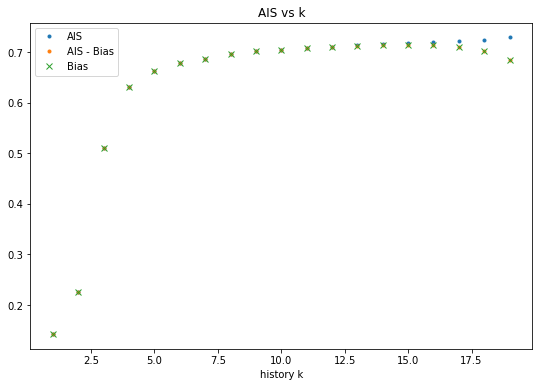

In [13]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 1, figsize=(9, 6))  
axs.plot(ks, results, '.', label='AIS')
axs.plot(ks, results_corrected, '.', label='AIS - Bias')
axs.plot(ks, results_corrected, 'x', label='Bias')
axs.set_title('AIS vs k')
axs.set_xlabel('Discrete AIS in bits')
axs.set_xlabel('history k')
plt.legend()
plt.show()

# Compute local information storage

## Selected K :  14

## Calculate local information storage, cell by cell (feature by feature)

In [24]:
import matplotlib.pyplot as plt

def plotLocal(local):

    print(type(local))
    if type(local) != list:
        print('not a list')
        return
        
    fig, axs = plt.subplots(1, 1, figsize=(9, 6))  
    axs.plot(locals[i], '.', label=f'localAIS cell {i}')
    axs.set_title('local AIs for cell I')
    axs.set_xlabel('time')
    plt.legend()
    plt.show()



def localAIS(source, history_k):
    # 1. Construct the calculator:
    calcClass = JPackage("infodynamics.measures.discrete").ActiveInformationCalculatorDiscrete
    calc = calcClass(2, history_k)
    # 2. No other properties to set for discrete calculators.

        


    locals=[]
    print(f'Processing local AIS for the {source.shape[1]} cells')
    print(f'Length of time: {len(source[:,0].tolist())}')

    for i in range(source.shape[1]):
        # 3. Initialise the calculator for (re-)use:
        calc.initialise()
        # 4. Supply the sample data:
        variable = javaIntList(source[:,i].tolist())
        calc.addObservations(variable)
        # 5. Compute the estimate:
        localAISForThisCell = calc.computeLocalFromPreviousObservations(variable)

        locals.append(np.array(localAISForThisCell))

    return locals

In [22]:
source.shape


(600, 10000)

In [25]:
locals = localAIS(source, 14)

Processing local AIS for the 10000 cells
Length of time: 600


In [33]:
locals_np = np.array(locals)
type(locals_np[0][1])

numpy.float64

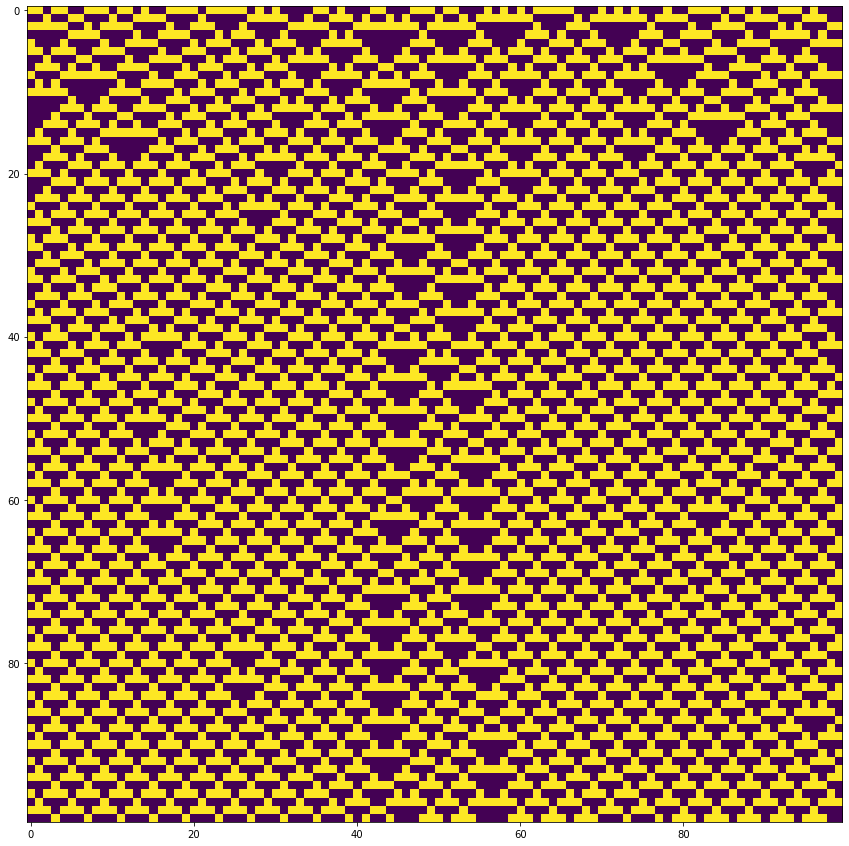

In [60]:
from PIL import Image
import matplotlib.pyplot as plt

im = Image.fromarray(source[0:100, 0:100].astype(np.uint8).reshape(100, 100))

fig, axs = plt.subplots(1,1,figsize=(15,15))
axs.grid(False)
axs.imshow(im)

Min AIS:  -5.327395531380094
Max AIS:  1.5654002343426383


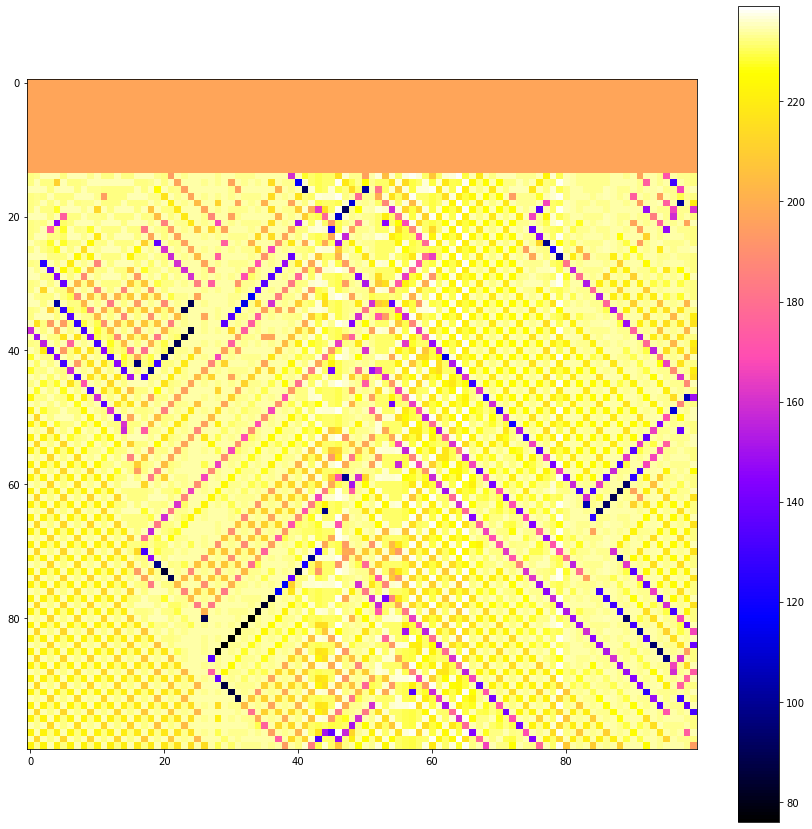

In [59]:

# convert values to 0 - 255 int8 format
locals_np_t = np.transpose(locals_np)
print('Min AIS: ', np.min(locals_np_t))
print('Max AIS: ', np.max(locals_np_t))
locals_np_formatted = (  ( locals_np_t - np.min(locals_np_t))  * 255 / ( np.max(locals_np_t) - np.min(locals_np_t))  ).astype('uint8')

cmap=plt.get_cmap('gnuplot2') #afmhot, cool, hot

im2 = Image.fromarray(locals_np_formatted[0:100, 0:100].reshape(100, 100))

fig, axs = plt.subplots(1,1,figsize=(15,15))
axs.grid(False)
plt.imshow(im2, cmap=cmap)

plt.colorbar()

plt.show()

In [ ]:
#https://izziswift.com/getting-individual-colors-from-a-color-map-in-matplotlib/

# MODULE 11 - Activity 5

In [1]:
# LOAD DATA FILE
#-------------------

import pandas as pd
#from pathlib import Path

filename = './data/ca54.txt'
data = pd.read_csv(filename, delim_whitespace=True, comment='%', header=None, index_col=None)
source = data.to_numpy()
source.shape

(600, 10000)

In [2]:

# 1. Construct the calculator:
calcClass = JPackage("infodynamics.measures.discrete").TransferEntropyCalculatorDiscrete
# base
# k_history (target)
# k_tau (target)
# i_history (source)
# i_tau (source)
# delay
calc = calcClass(2, 1, 1, 1, 1, 1)
# 2. No other properties to set for discrete calculators.
# 3. Initialise the calculator for (re-)use:
calc.initialise()
# 4. Supply the sample data:
calc.addObservations(source, target)
# 5. Compute the estimate:
result = calc.computeAverageLocalOfObservations()

locals = calc.computeLocalFromPreviousObservations(source, target)

print("TE_Discrete(col_0 -> col_1) = %.4f bits" %
    (result))

NameError: name 'JPackage' is not defined